In [ ]:
!pip install pyspark


In [1]:
import os
os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'
import pandas as pd
import numpy as np
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col,min,max,mean
import time
from pyspark.sql.functions import col, when, count, sum
import matplotlib.pyplot as plt

In [2]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType, DoubleType, TimestampType

# Schéma de la donnée
schema = StructType([
    StructField("event_time", TimestampType(), True),
    StructField("event_type", StringType(), True),
    StructField("product_id", IntegerType(), True),
    StructField("category_id", LongType(), True),
    StructField("category_code", StringType(), True),
    StructField("brand", StringType(), True),
    StructField("price", DoubleType(), True),
    StructField("user_id", IntegerType(), True),
    StructField("user_session", StringType(), True)
])


In [3]:
spark = SparkSession.builder \
    .appName("Lire CSV avec PySpark") \
    .getOrCreate()

24/06/12 12:57:39 WARN Utils: Your hostname, ghani-IdeaPad-3-14ADA05 resolves to a loopback address: 127.0.1.1, but we couldn't find any external IP address!
24/06/12 12:57:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/12 12:57:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/06/12 12:57:40 WARN MacAddressUtil: Failed to find a usable hardware address from the network interfaces; using random bytes: e8:a0:a2:db:38:7d:95:7c
24/06/12 12:57:40 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/06/12 12:57:40 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [4]:
oct_df = spark.read.csv("/home/ghani/Téléchargements/2019-Oct.csv",
    header=True,         
    schema=schema,       

    
)

In [5]:
 nombre_lignes_oct = oct_df.count()
# nombre_lignes_nov = nov_df.count()
# nombre_lignes_dec = dec_df.count()
# nombre_lignes_jan = jan_df.count()
#nombre_lignes_feb = feb_df.count()
# nombre_lignes_mar = mar_df.count()
# nombre_lignes_apr = apr_df.count()

# print(f" OCT: {oct_df.printSchema()}")
# print(f"NOV: {nov_df.printSchema()}")
# print(f"DEC: {dec_df.printSchema()}")
# print(f"JAN: {jan_df.printSchema()}")
#print(f"FEB: {feb_df.printSchema()}")
# print(f"MAR: {mar_df.printSchema()}")
# print(f"APR: {apr_df.printSchema()}")


 print(f"Nombre de lignes OCT: {nombre_lignes_oct}")
# print(f"Nombre de lignes NOV: {nombre_lignes_nov}")
# print(f"Nombre de lignes DEC: {nombre_lignes_dec}")
# print(f"Nombre de lignes JAN: {nombre_lignes_jan}")
#print(f"Nombre de lignes FEB: {nombre_lignes_feb}")
# print(f"Nombre de lignes MAR: {nombre_lignes_mar}")
# print(f"Nombre de lignes APR: {nombre_lignes_apr}")

Nombre de lignes OCT: 42448764


In [7]:
oct_df.show()
# nov_df.show()
# dec_df.show()
# jan_df.show()
#feb_df.show()
# mar_df.show()
# apr_df.show()

+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 02:00:00|      view|  44600062|2103807459595387724|                NULL|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|
|2019-10-01 02:00:00|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|   33.2|554748717|9333dfbd-b87a-470...|
|2019-10-01 02:00:01|      view|  17200506|2053013559792632471|furniture.living_...|    NULL|  543.1|519107250|566511c2-e2e3-422...|
|2019-10-01 02:00:01|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 02:00:04|      view|   1004237|2053013555631882655|electr

In [78]:
counts =oct_df.select([count((col(c))).alias(c) for c in oct_df.columns])
counts.show()

+----------+----------+----------+-----------+-------------+--------+--------+--------+------------+
|event_time|event_type|product_id|category_id|category_code|   brand|   price| user_id|user_session|
+----------+----------+----------+-----------+-------------+--------+--------+--------+------------+
|  42448764|  42448764|  42448764|   42448764|     28933155|36335756|42448764|42448764|    42448762|
+----------+----------+----------+-----------+-------------+--------+--------+--------+------------+



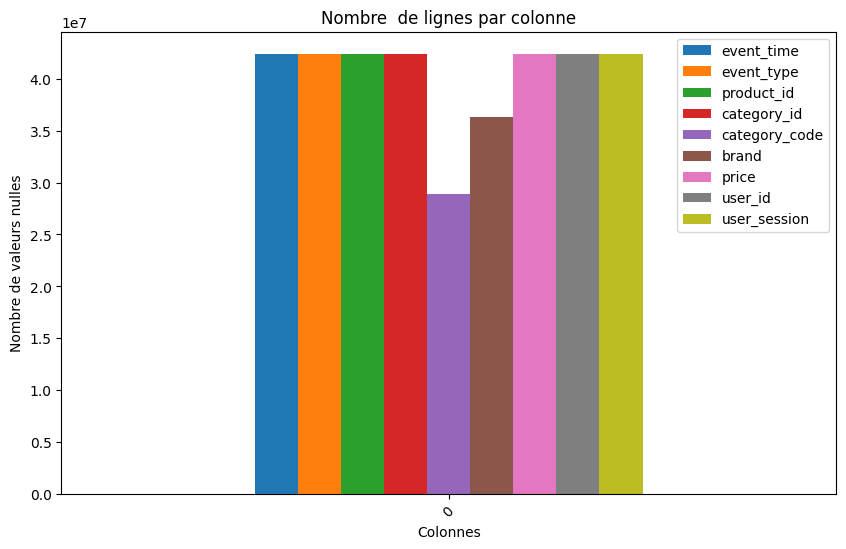

In [79]:

nb_element = counts.toPandas()
nb_element.plot(kind='bar', figsize=(10, 6))
plt.title('Nombre  de lignes par colonne')
plt.xlabel('Colonnes')
plt.ylabel('Nombre de valeurs nulles')
plt.xticks(rotation=45)
plt.show()


In [80]:
null_counts =oct_df.select([count(when(col(c).isNull(), c)).alias(c) for c in oct_df.columns])
#null_counts.show()


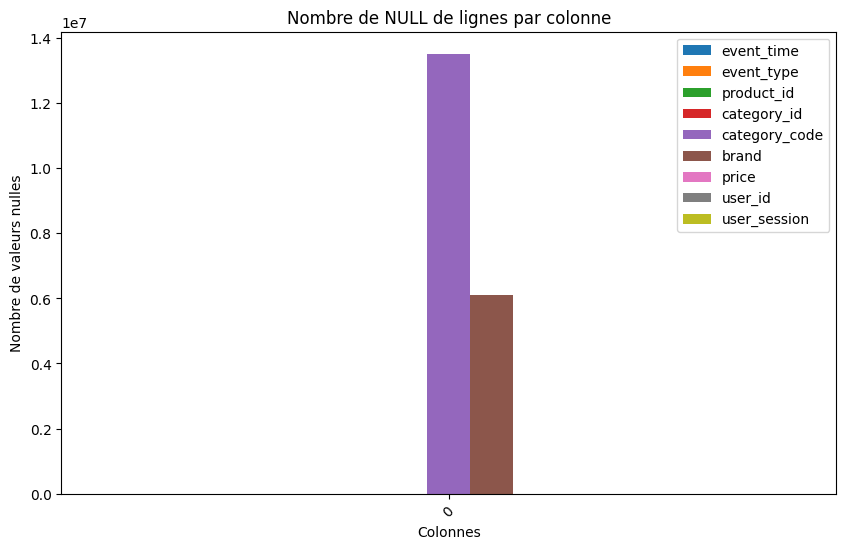

In [81]:
null_counts_pdf = null_counts.toPandas()
null_counts_pdf.plot(kind='bar', figsize=(10, 6))
plt.title('Nombre de NULL de lignes par colonne')
plt.xlabel('Colonnes')
plt.ylabel('Nombre de valeurs nulles')
plt.xticks(rotation=45)
plt.show()


In [11]:

unique_user_count = oct_df.select("user_id").distinct().count()

print(f"Nombre de lignes uniques pour la colonne user_id: {unique_user_count}")


Nombre de lignes uniques pour la colonne user_id: 3022290


In [64]:
df = oct_df.dropDuplicates()

In [82]:
df = df.filter((df["category_code"].isNotNull() )&(df["brand"].isNotNull()))

In [83]:
null_counts_after =df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

24/06/11 22:50:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:50:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:50:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:50:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:50:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:50:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:50:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:50:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:50:32 WARN RowBasedKeyValueBatch: Calling spill() on

24/06/11 22:51:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:51:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:51:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:51:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:51:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:51:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:51:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:51:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:51:07 WARN RowBasedKeyValueBatch: Calling spill() on

24/06/11 22:51:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:51:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:51:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:51:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:51:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:51:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:51:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:51:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:51:41 WARN RowBasedKeyValueBatch: Calling spill() on

24/06/11 22:51:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:51:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:51:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:51:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:51:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:51:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:51:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:51:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:51:58 WARN RowBasedKeyValueBatch: Calling spill() on

24/06/11 22:52:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:52:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:52:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:52:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:52:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:52:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:52:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:52:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/11 22:52:07 WARN RowBasedKeyValueBatch: Calling spill() on

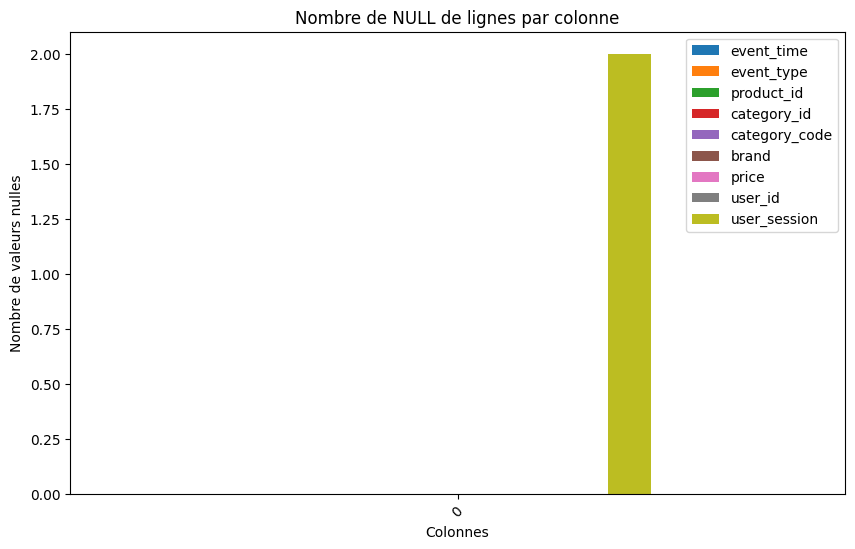

In [84]:
null_counts_after_df = null_counts_after.toPandas()
null_counts_after_df.plot(kind='bar', figsize=(10, 6))
plt.title('Nombre de NULL de lignes par colonne')
plt.xlabel('Colonnes')
plt.ylabel('Nombre de valeurs nulles')
plt.xticks(rotation=45)
plt.show()


In [152]:
from pyspark.sql.functions import col

print(df.count())

42349874


In [153]:
print(df.count())


42349874


In [ ]:



col_name = "category_code"


df=oct_df.filter(col(col_name).isNull())
category_code_empty_count = oct_df.filter(col(col_name) == '').count()

print("Nombre de valeurs nulles dans la colonne '{}': {}".format(col_name, category_code_null_count))
print("Nombre de lignes vides dans la colonne '{}': {}".format(col_name, category_code_empty_count))

In [12]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, count, sum, min, max, mean
from pyspark.sql.types import IntegerType, FloatType
import datetime
from pyspark.sql.functions import year, month, dayofmonth, hour, datediff, lit
from pyspark.sql.types import IntegerType, FloatType
import datetime

# Créer des caractéristiques supplémentaires
data = data.withColumn("year", year(col("event_time")))
data = data.withColumn("month", month(col("event_time")))
data = data.withColumn("day", dayofmonth(col("event_time")))
data = data.withColumn("hour", hour(col("event_time")))

# Filtrer les événements d'achat
purchases = data.filter(data.event_type == 'purchase')

# Calcul de la fréquence d'achat et du montant total dépensé par utilisateur
user_features = purchases.groupBy("user_id").agg(
    sum("price").alias("total_spent"),
    count("product_id").alias("purchase_count"),
    min("event_time").alias("first_purchase"),
    max("event_time").alias("last_purchase")
)

# Calcul de la récence et de la fréquence
current_date = datetime.datetime.now()
user_features = user_features.withColumn("recency", datediff(lit(current_date), col("last_purchase")))

# Définir une fonction UDF pour calculer la fréquence d'achat
def calculate_frequency(first, last, count):
    if count > 0:
        return (last - first).days / count
    else:
        return 0

from pyspark.sql.functions import udf
frequency_udf = udf(calculate_frequency, FloatType())
user_features = user_features.withColumn("frequency", frequency_udf(col("first_purchase"), col("last_purchase"), col("purchase_count")))

user_features.show()

# Initialiser une session Spark
spark = SparkSession.builder.appName("CustomerSegmentation").getOrCreate()

# Charger les données
data = spark.read.csv('/home/ghani/Téléchargements/2019-Oct.csv', header=True, schema=schema,   inferSchema=True)





# Filtrer les événements d'achat
purchases = data.filter(data.event_type == 'purchase')

# Créer des caractéristiques supplémentaires
purchases = purchases.withColumn("year", col("event_time").cast("year"))
purchases = purchases.withColumn("month", col("event_time").cast("month"))
purchases = purchases.withColumn("day", col("event_time").cast("day"))
purchases = purchases.withColumn("hour", col("event_time").cast("hour"))

# Calcul de la fréquence d'achat et du montant total dépensé par utilisateur
user_features = purchases.groupBy("user_id").agg(
    sum("price").alias("total_spent"),
    count("product_id").alias("purchase_count"),
    min("event_time").alias("first_purchase"),
    max("event_time").alias("last_purchase")
)

# Calcul de la récence et de la fréquence
current_date = datetime.datetime.now()
recency_udf = udf(lambda x: (current_date - x).days, IntegerType())
user_features = user_features.withColumn("recency", recency_udf(col("last_purchase")))

frequency_udf = udf(lambda x, y, z: (y - x).days / z if z > 0 else 0, FloatType())
user_features = user_features.withColumn("frequency", frequency_udf(col("first_purchase"), col("last_purchase"), col("purchase_count")))

user_features.show()


NameError: name 'data' is not defined

24/06/12 20:57:45 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 27551997 ms exceeds timeout 120000 ms
24/06/12 20:57:45 WARN SparkContext: Killing executors is not supported by current scheduler.
24/06/12 20:57:47 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint

24/06/12 20:57:57 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/06/12 20:58:07 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)